# Stage 1: Map Matching

## **Input**: trajectories, 

## **Output**: each GPS point should have one corresponding matched road segment.


In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.functional as F
import os, sys
import math
from shapely.geometry import shape, Point, LineString, MultiLineString
from sklearn.metrics.pairwise import haversine_distances 


RADIUS_OF_EARTH_M = 6371000
MILES_PER_METER = 0.000621371
HOURS_PER_SECOND = 3600.0

# Basic Algorithm

In [2]:
# great circle distance 
def great_circle_dist_x_to_z(x, z):
    # convert decimal degrees to radians 
    x = np.deg2rad(x)
    z = np.deg2rad(z)
    
    longitude = z[1]
    latitude = z[0]
    prev_longitude = x[1]
    prev_latitude = x[0]
    
    # haversine formula 
    dlon = longitude - prev_longitude # lon2 - lon1 
    dlat = latitude - prev_latitude # lat2 - lat1 
    
    # a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    a = np.add(np.square(np.sin(dlat / 2)),
               np.multiply(np.cos(prev_latitude), 
                           np.multiply(np.cos(latitude), np.square(np.sin(dlon / 2)))
                          )
              )
    
    # c = 2 * asin(sqrt(a)) 
    c = np.arcsin(np.sqrt(a)) * 2
    
    return RADIUS_OF_EARTH_M * c

In [3]:
# great circle distance 
def great_circle_dist_z_to_z(df):
    # convert decimal degrees to radians 
    df = df.copy()
    df = np.deg2rad(df)
    
    longitude = df[:, 3]
    latitude = df[:, 2]
    prev_longitude = df[:, 1]
    prev_latitude = df[:, 0]
    
    # haversine formula 
    dlon = longitude - prev_longitude # lon2 - lon1 
    dlat = latitude - prev_latitude # lat2 - lat1 
    
    # a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    a = np.add(np.square(np.sin(dlat / 2)),
               np.multiply(np.cos(prev_latitude), 
                           np.multiply(np.cos(latitude), np.square(np.sin(dlon / 2)))
                          )
              )
    
    # c = 2 * asin(sqrt(a)) 
    c = np.arcsin(np.sqrt(a)) * 2
    
    return RADIUS_OF_EARTH_M * c

In [4]:
# get the x_t_i
def get_perpendicular_point(point, line):
    # point: (x, y)
    # line: ((x1, y1), (x2, y2))
    
    x, y = point
    x1, y1 = line[0]
    x2, y2 = line[1]
    
    # calculate the slope of the line
    if x2 - x1 == 0:
        # vertical line
        x_intersect = x1
        y_intersect = y
    else:
        slope = (y2 - y1) / (x2 - x1)
        intercept = y1 - slope * x1
    
        # calculate the intersection point of the line and the perpendicular line
        x_intersect = (slope*y + x - slope*intercept) / (slope**2 + 1)
        y_intersect = (slope*x_intersect) + intercept
        
    return [x_intersect, y_intersect]

# HMM Model

In [5]:
## HMM model
class HMMModel(nn.Module):
    def __init__(self, sigma = 4.07, beta = 3.0, normalize=True, 
                 prob_floor=0.0, n = 50, viterbi_trellis=[], 
                 prev_candidate_roads = [], viterbi_list =[]):
        self.normalize = normalize
        self.prob_floor = min(max(prob_floor, 0), 1)
        self.n = n
        self.sigma = sigma
        self.beta = beta
        self.weights = np.zeros((1, self.n))
        self.viterbi_trellis = viterbi_trellis  # list of particle np arrays
        self.prev_candidate_roads = prev_candidate_roads
        self.viterbi_list = viterbi_list
      
    def apply_emission_model(self, sampled_states, obs_coords):
        # TODO: simplify the code below
        # get the sigma 
        # 1.4826 median𝑡(‖𝑧𝑡 − 𝑥𝑡,𝑖∗‖𝑔𝑟𝑒𝑎𝑡-𝑐𝑖𝑟𝑐𝑙𝑒)
        
        probs = []
        for obs in sampled_states:
            # ‖𝑧𝑡 − 𝑥𝑡,𝑖‖𝑔𝑟𝑒𝑎𝑡-𝑐𝑖𝑟𝑐𝑙𝑒
            dist_obs_roads = obs[1].Z_t_TO_X_t_i
            
            # 𝑝(𝑧𝑡|𝑟𝑖)
            probs.append(np.exp(np.power(dist_obs_roads / self.sigma, 2) * (-0.5)) * (1 / (math.sqrt(2 * math.pi) * self.sigma)))

        # Normalize result
        if self.normalize:
            probs = probs / np.sum(probs)
        return probs
    
    def apply_transition_model(self, candidate_roads, dist_prev):
        # TODO: simplify the code below
        # get the beta
        # 𝛽 = 1/ln(2) mediant (|‖𝑧𝑡 − 𝑧𝑡+1‖𝑔𝑟𝑒𝑎𝑡-𝑐𝑖𝑟𝑐𝑙𝑒 − ‖𝑥𝑡,𝑖∗ −𝑥𝑡+1,𝑗∗‖𝑟𝑜𝑢𝑡𝑒|)
        
        probs = []
        # NOTE: ‖𝑧𝑡 − 𝑧𝑡+1‖𝑔𝑟𝑒𝑎𝑡-𝑐𝑖𝑟𝑐𝑙𝑒 is given by dist_prev
        for point in candidate_roads:
            prob = []
            for prev_point in self.prev_candidate_roads:
                # calculate ‖𝑥𝑡,𝑖 − 𝑥𝑡+1,𝑗‖𝑟𝑜𝑢𝑡𝑒 
                # TODO: need to recalculate the route
                dist_road = great_circle_dist_x_to_z(prev_point[1].X_t_i, point[1].X_t_i)
                
                # TODO: terminate the search for a route when ‖𝑥𝑡,𝑖 − 𝑥𝑡+1,𝑗‖𝑟𝑜𝑢𝑡𝑒 
                # becomes greater than ‖𝑧𝑡 − 𝑧𝑡+1‖𝑔𝑟𝑒𝑎𝑡-𝑐𝑖𝑟𝑐𝑙𝑒 by 2000 meters
                # or more, and assign a probability of zero.
                
                # calculate the difference between ‖𝑧𝑡 − 𝑧𝑡+1‖𝑔𝑟𝑒𝑎𝑡-𝑐𝑖𝑟𝑐𝑙𝑒 and ‖𝑥𝑡,𝑖 − 𝑥𝑡+1,𝑗‖𝑟𝑜𝑢𝑡𝑒
                diff_dist = np.abs(np.subtract(dist_road, dist_prev))
                
                # calculate the transition probability
                prob.append(np.exp(-diff_dist / self.beta) * (1 / self.beta))
                
            probs.append(prob)
        
        # Normalize result?
        if self.normalize:
            probs = probs / np.sum(probs)
        return probs  # the probs is a list of lists transition prob
    
    def update_dist(self, obs, candidate_roads, num_iter, n, max_dist2=None):
        longitude = obs[1].longitude
        latitude = obs[1].latitude
        
        # n depends on how many candidate roads you have at time t
        self.n = n
        
        obs_coords = [latitude, longitude] 
        dist_prev = obs[1].dist_from_prev_m
        
        # transition probability
        if num_iter > 1:
            
            trans_probs = self.apply_transition_model(candidate_roads, 
                                                      dist_prev) # (n * c, 1) first n rows for first candidate, etc.
            sampled_states = candidate_roads
#             print("Transition: ")
#             print(trans_probs)
#             print("--------------------------------------------------------------")
        else:
            sampled_states = candidate_roads
        
        # emission probabilities
        emission_probs = self.apply_emission_model(sampled_states, obs_coords) # (n, 1)
#         print("Emission: ")
#         print(emission_probs)
#         print("--------------------------------------------------------------")
        
        # Joint prob, for viterbi backtracking.
        if num_iter > 1:
            # since the num_iter is different we need to v(j)
            max_v_list = []
            max_v = 0
            for i in range(len(emission_probs)):
                for j in range(len(trans_probs[i])):
                    # get the Recursion
                    joint = np.multiply(self.weights[j], np.multiply(emission_probs[i], trans_probs[i][j]))
                    if max_v < joint:
                        max_v = joint
                max_v_list.append(max_v)
                max_v = 0
#             print("Max_v: ")
#             print(max_v_list)
#             print("--------------------------------------------------------------")
            # the recursion for other states
            joint_prob = max_v_list
            # for other states, the prob for each road is the joint_prob
            self.viterbi_trellis.append(joint_prob)
            self.viterbi_list.append(candidate_roads)
        else:
            # the recursion for the first state
            joint_prob = emission_probs
            # since it is the first state, the prob for each road is the emission itself
            self.viterbi_trellis.append(joint_prob)
            # remember each candidate_roads place
            self.viterbi_list.append(candidate_roads)
            
        # rememeber the previous recursion
        self.weights = joint_prob
        # remember the previous candidate_roads
        self.prev_candidate_roads = candidate_roads
        
        # Estimate current particle filter fit quality of hypotheses to data; should research good metrics more.
        fit_quality = [np.max(self.weights), np.mean(self.weights), np.median(self.weights)]
        
        return fit_quality
    
    def viterbi(self):
        # Start with the last observation to the viterbi trellis
        best_last_state_idx = np.argmax(self.weights)
        backtracked_states = []
        # Backtrack through the viterbi trellis (#obs, n, 2) actual lat/long states
        for j in range(len(self.viterbi_trellis) - 1 , -1, -1):
            best_last_state = self.viterbi_list[j][best_last_state_idx]
            backtracked_states.append([best_last_state[1].StartNodeLat, best_last_state[1].StartNodeLong])
            best_last_state_idx = np.argmax(self.viterbi_trellis[j - 1])
        # Put in chronological order
        backtracked_states = backtracked_states[::-1]
        return backtracked_states

# Preprocess Data & Grab the Candidate road

In [6]:
# preprocess the data
def preprocess_traces(df, sigma=4.07):
    data = df.copy()
    data[["prev_latitude", "prev_longitude"]] = data[["latitude", "longitude"]].shift(-1)
    # Ignore warning about invalid value in arcsin (nan)
    data["dist_from_prev_m"] = great_circle_dist_z_to_z(data[["prev_latitude", "prev_longitude", "latitude", "longitude"]].values)  # 1.93 sec
    # Take cumsum of dist
    dist_cum = data.dist_from_prev_m.cumsum()
    # removing points that are within 2𝜎 of the previous included point.
    # Select points closest to multiples of 2*sigma, in cumsum dist
    dist_cum_idx = dist_cum // (2 * sigma)
    filter_idx = np.subtract(dist_cum_idx, dist_cum_idx.shift(1)) == 0
    data = data[~filter_idx]
    
    # seperate the route based on the occupancy
    trips_list = []
    trip = []
    # for loop all the point
    for obs in data.iterrows():
        # if this point's occupancy is 1
        if obs[1].occupancy == 1:
            trip.append(obs)
        else:
            trips_list.append(trip)
            trip = []
    trips_list = [x for x in trips_list if x != []]
    return trips_list

In [7]:
# preprocess the Map
def preprocess_Map(data_edge, data_node):
    data_node.rename(columns = {'NodeID':'StartNodeID'}, inplace = True)
    data_node.rename(columns = {'Longitude':'StartNodeLong'}, inplace = True)
    data_node.rename(columns = {'Latitude':'StartNodeLat'}, inplace = True)
    df_merge = pd.merge(data_edge, data_node, on="StartNodeID")

    data_node.rename(columns = {'StartNodeID':'EndNodeID'}, inplace = True)
    data_node.rename(columns = {'StartNodeLong':'EndNodeLong'}, inplace = True)
    data_node.rename(columns = {'StartNodeLat':'EndNodeLat'}, inplace = True)
    df_merge = pd.merge(df_merge, data_node, on="EndNodeID")
    return df_merge

In [8]:
# get the candidate road
# TODO: 
# Since we know we are tracking ordinary vehicles on public streets, if a 
# calculated route would require the vehicle to exceed a speed of 50 m/s 
# (112 miles per hour, 180 kilometers per hour), or travel in excess of 
# three times the posted speed limit, we consider the route to be unreasonable,
# and set its probability to zero.

def get_candidate_roads(Map, data):
    # [candidate road for time 0, candidate road for time 1,....]
    candidate_roads = [] 
    # let's get the candidate roads for each time t
    for obs in data:
        # get the lat and long for the point
        z_long = obs[1].longitude
        z_lat = obs[1].latitude
        z = [z_lat, z_long]
        # match the coords and the dataset
        candidate_road = []
        for edge in Map.iterrows():
            p1 = np.array([edge[1].StartNodeLat, edge[1].StartNodeLong])
            p2 = np.array([edge[1].EndNodeLat, edge[1].EndNodeLong])
            p3 = np.array(z)
            
            # 𝑥𝑡,𝑖: the perpendicular point from the z to the road 
            x_t_i = get_perpendicular_point(p3, (p1, p2))
            
            # check if 𝑥𝑡,𝑖 is on the line
            dist_p1_x = great_circle_dist_x_to_z(p1, x_t_i)
            dist_p2_x = great_circle_dist_x_to_z(p2, x_t_i)
            dist_p1_p2 = great_circle_dist_x_to_z(p1, p2)
            
            if ((dist_p1_x + dist_p2_x) - dist_p1_p2)/2 > 200:
                continue
            
            # calculate the distance from the point to the road
            d = great_circle_dist_x_to_z(p3, x_t_i)
            
            # Any road segment more than 200 meters away from the GPS point.
            if d < 200:
#                 print(p1)
#                 print(p2)
#                 print(p3)
#                 print(x_t_i)
                edge[1]['X_t_i'] = x_t_i
                edge[1]['Z_t_TO_X_t_i'] = d
                edge[1]['Z_t_TO_Z_t1'] = obs[1].dist_from_prev_m
                candidate_road.append(edge)
                
        # TODO: When a break is detected between time step 𝑡 and time step 𝑡 + 1, 
        # we remove measured points 𝑧𝑡 and 𝑧𝑡+1 from the model, and check to see 
        # if the break has been healed. The break is considered healed if the 
        # measured points at 𝑡 − 1 and 𝑡 + 2 lead to a reconnection in the HMM 
        # after rechecking the points with the bulleted conditions above. If the 
        # break is still present, we continue to remove the points on either side 
        # of the break until either the break is healed, or the break is more than 
        # 180 seconds long. 
        if len(candidate_road) == 0:
            print("No matching roads found within max road distance! Aborting particle filter.")
            return None
        candidate_roads.append(candidate_road)
    return candidate_roads

# Load the Data and Training

In [9]:
# get the training path
train_path = '/Users/richard/Downloads/for_student/training'
# Node_path = '/Users/richard/Downloads/for_student/road_network_in_CA/node.txt'
# Edge_path = '/Users/richard/Downloads/for_student/road_network_in_CA/edge.txt'
node_path = '/Users/richard/Downloads/for_student/Map.txt'

In [10]:
# get the Map
# data_edge = pd.read_csv(Edge_path, sep=' ')
# data_node = pd.read_csv(Node_path, sep=' ')

Map = pd.read_csv(node_path, sep=' ')

# Map = preprocess_Map(data_edge, data_node)

In [19]:
# get all the files in the training folder
all_files = [f for f in os.listdir(train_path)]

# read the 1st file in the folder as a test case
train_df = pd.read_csv(os.path.join(train_path, all_files[0]), sep=" ", index_col=None, header=None, 
                      names=['latitude', 'longitude', 'occupancy', 'time'])

# convert the time from unix into date time
train_df.loc[:, ["time"]] = pd.to_datetime(train_df.time, origin="unix", unit='s')

# preprocess the data
trips_list = preprocess_traces(train_df)


# pick one trip for HMM training
# [0, 1, 129, 130, 131, 132, 133, 134, 135]
trip = trips_list[131]

# get the candidate roads
candidate_roads = get_candidate_roads(Map, trip)

In [13]:
# initialize the model
model = HMMModel()

# training
def train(data, candidate_roads):
    data = data.copy()
    num_iter = 0
    converged = False
    for obs in data:
        num_iter += 1
        fit_quality = model.update_dist(obs, candidate_roads[num_iter-1], num_iter, len(candidate_roads[num_iter-1]))
        if fit_quality == "Aborted":
            return "Aborted"
        print("On iteration %d, fit quality of MAX %3.2f, MEAN %3.2f, MEDIAN %3.2f" % 
              (num_iter, fit_quality[0], fit_quality[1], fit_quality[2]))
    print("Done.")

train(trip, candidate_roads)

On iteration 1, fit quality of MAX 1.00, MEAN 1.00, MEDIAN 1.00
On iteration 2, fit quality of MAX 1.00, MEAN 1.00, MEDIAN 1.00
On iteration 3, fit quality of MAX 0.99, MEAN 0.49, MEDIAN 0.49
On iteration 4, fit quality of MAX 0.00, MEAN 0.00, MEDIAN 0.00
On iteration 5, fit quality of MAX 0.00, MEAN 0.00, MEDIAN 0.00
Done.


# Get the result from model

In [14]:
backtracked_trace = model.viterbi()
print(backtracked_trace)

[[37.7866, -122.4149], [37.7866, -122.4149], [37.7861, -122.4179], [37.7861, -122.4179], [37.7806, -122.4169]]


# Visualization

[[37.78634, -122.41464], [37.78632, -122.41474], [37.78511, -122.41789], [37.78122, -122.41717], [37.78075, -122.41538]]


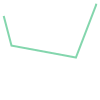

In [15]:
# print(trip[1].latitdue)
trip_list = []
for point in trip:
    trip_list.append([point[1].latitude, point[1].longitude])
print(trip_list)
LineString(trip_list)

[[37.7866, -122.4149], [37.7866, -122.4149], [37.7861, -122.4179], [37.7861, -122.4179], [37.7806, -122.4169]]


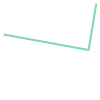

In [16]:
trip_list = []
for point in backtracked_trace:
    trip_list.append([point[0], point[1]])
print(trip_list)
LineString(trip_list)

In [17]:
# libraries for map visualization

import networkx as nx
import folium

# Add the standard road network

df_node_SF = Map[Map['StartNodeLong'].between(-122.524, -122.345, inclusive=True)]
df_node_SF = df_node_SF[df_node_SF['StartNodeLat'].between(37.702, 37.812, inclusive=True)]
df_node_SF.reset_index(inplace = True, drop = True)

# Add the matched roads
matched_fg = folium.FeatureGroup(name='Matched Roads')

for i in range(len(trip_list)):

    # Draw traces
    if i < len(trip_list)-1:
        traces = folium.PolyLine(locations=[trip_list[i], trip_list[i+1]], weight=3, color='Green')
    
    # Add the polyline to the feature group
    matched_fg.add_child(traces)

# Trip picked for HMM Training
trip_fg = folium.FeatureGroup(name='One Trip for HMM Training')


for i in range(len(trip)):

    # Draw traces
    current_coord = [trip[i][1][0], trip[i][1][1]]
    previous_coord = [trip[i][1][4], trip[i][1][5]]
    traces = folium.PolyLine(locations=[previous_coord, current_coord], weight=3, color='Blue')

    # Add to the feature group
    trip_fg.add_child(traces)


# Create a map centered at San Francisco
sf_map = folium.Map(location=[37.759457, -122.444781], zoom_start=12, prefer_canvas=True, control_scale=True)

# Add the feature groups to the map
# sf_map.add_child(network_fg)
sf_map.add_child(matched_fg)
sf_map.add_child(trip_fg)

# Add a layer control feature
folium.LayerControl().add_to(sf_map)

# Add click for coords feature
sf_map.add_child(folium.LatLngPopup())

# save map
#sf_map.save('SF_MAP.html')

# display map
sf_map

    StartNodeLat  StartNodeLong  EndNodeLat  EndNodeLong
0        37.7841      -122.3986     37.7838    -122.3989
1        37.7838      -122.3989     37.7850    -122.4005
2        37.7850      -122.4005     37.7862    -122.4020
3        37.7862      -122.4020     37.7875    -122.4034
4        37.7875      -122.4034     37.7879    -122.4035
..           ...            ...         ...          ...
88       37.7857      -122.4064     37.7855    -122.4079
89       37.7855      -122.4079     37.7849    -122.4078
90       37.7866      -122.4149     37.7861    -122.4179
91       37.7861      -122.4179     37.7806    -122.4169
92       37.7806      -122.4169     37.7807    -122.4153

[93 rows x 4 columns]


/var/folders/wd/z38sgpjj2yx5qdc96wz1cdn80000gn/T/ipykernel_67876/1761750590.py:8: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  df_node_SF = Map[Map['StartNodeLong'].between(-122.524, -122.345, inclusive=True)]
/var/folders/wd/z38sgpjj2yx5qdc96wz1cdn80000gn/T/ipykernel_67876/1761750590.py:9: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  df_node_SF = df_node_SF[df_node_SF['StartNodeLat'].between(37.702, 37.812, inclusive=True)]
